# Setup

In [1]:
# Standard library
import os
import warnings
# Third-party: core data
import numpy as np
import pandas as pd
# Third-party: visualization
import matplotlib.pyplot as plt
# Third-party: survival analysis (lifelines)
from lifelines import (
    KaplanMeierFitter,
    NelsonAalenFitter,
    CoxPHFitter,
)
from lifelines.statistics import (
    logrank_test,
    pairwise_logrank_test,
)
# Third-party: survival ML (scikit-survival)
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import (
    brier_score,
    concordance_index_censored,
    integrated_brier_score,
)
from sksurv.util import Surv

# Configuration & warnings
warnings.simplefilter("ignore", FutureWarning)


This section of code imports various Python libraries commonly used in survival analysis and machine learning tasks related to time-to-event data. 

First, it includes modules from the standard Python library: `os` for interacting with the operating system (like file paths), and `warnings` to manage warning messages during execution.

Next, it brings in core data science libraries: `numpy` for numerical operations, especially working with arrays, and `pandas` for data manipulation and analysis using DataFrames. 

Then, visualization is enabled through `matplotlib.pyplot`, which allows the creation of plots and charts.

The code then imports specific tools from the `lifelines` library, a dedicated package for survival analysis. This includes classes like `KaplanMeierFitter` (for estimating survival curves), `NelsonAalenFitter` (for cumulative hazard functions), and `CoxPHFitter` (for fitting Cox proportional hazards models). It also imports statistical tests such as `logrank_test` and `pairwise_logrank_test` for comparing survival distributions between groups.

Following that, the code incorporates libraries from `scikit-survival`, a package integrating survival analysis with scikit-learn’s machine learning framework.  This includes ensemble methods like `RandomSurvivalForest`, linear models such as `CoxPHSurvivalAnalysis`, and metrics for evaluating survival prediction models (`brier_score`, `concordance_index_censored`, `integrated_brier_score`). The `Surv` object is also imported, which represents time-to-event data with censoring information in a format compatible with scikit-survival.

Finally, the code configures warning handling by suppressing `FutureWarning` messages, which are often related to upcoming changes in library behavior and can clutter output without necessarily indicating an error.

In [2]:
# general settings
class CFG:
    data_folder = './data/'
    graph_folder = './graphs/'
    img_dim1 = 20
    img_dim2 = 10
    SEED = 42
    metric = 'rmse'


# display style 
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (CFG.img_dim1, CFG.img_dim2)

np.random.seed(CFG.SEED)

This code establishes general settings and visual style configurations for a project. 

A class named `CFG` is defined to hold various configuration parameters. It specifies the directories for data (`data_folder`) and generated graphs (`graph_folder`), sets dimensions for images (`img_dim1`, `img_dim2`), defines a random seed (`SEED`) for reproducibility, and indicates the evaluation metric to be used (`metric`).

Next, the code adjusts the plotting style using Matplotlib. It applies the "seaborn-v0_8" style theme and sets the default figure size based on the image dimensions defined in the `CFG` class. 

Lastly, it initializes the NumPy random number generator with the seed value specified in `CFG`, ensuring that any randomized operations produce consistent results across multiple runs of the code.

# Utils

In [3]:
def compute_cindex(preds, y_test, event_column, time_column):
    return concordance_index_censored(
        y_test[event_column].astype(bool),
        y_test[time_column],
        preds
    )[0]

This code defines a function called `compute_cindex` that calculates the C-index, a metric used to evaluate the performance of survival prediction models.

The function takes four arguments: `preds` (predicted risk scores from the model), `y_test` (the true time-to-event data for the test set), `event_column` (the name of the column in `y_test` indicating whether an event occurred), and `time_column` (the name of the column in `y_test` representing the observed time).

Inside the function, it calls the `concordance_index_censored` function from the `scikit-survival.metrics` module. This function computes the C-index based on the provided event status (`y_test[event_column].astype(bool)` converts the event indicator to a boolean type), observed times (`y_test[time_column]`), and predicted risk scores (`preds`). 

The `[0]` at the end extracts the C-index value from the output of `concordance_index_censored`, which returns multiple values; only the primary C-index is returned by this function. The resulting C-index, a value between 0 and 1 (higher values indicate better performance), is then returned by the `compute_cindex` function.TODO

# Basic toolkit

In [4]:
df = pd.read_csv(CFG.data_folder + 'WA_Fn-UseC_-Telco-Customer-Churn.csv')
df['churn'] = [1 if x == 'Yes' else 0 for x in df['Churn']]
df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.5,No,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1


This code reads data from a CSV file and performs an initial transformation on one of its columns.

First, it uses the `pd.read_csv` function from the Pandas library to load data from a CSV file located at the path specified by joining the `data_folder` attribute of the `CFG` class with the filename 'WA_Fn-UseC_-Telco-Customer-Churn.csv'. The resulting DataFrame is assigned to the variable `df`.

Next, it creates a new column named ‘churn’ in the DataFrame. This column is populated based on the values in the original ‘Churn’ column: if a value in the ‘Churn’ column is equal to 'Yes', the corresponding value in the ‘churn’ column will be 1; otherwise, it will be 0.  This effectively converts the categorical churn indicator ('Yes' or 'No') into a numerical representation (1 or 0).

Finally, `df.head(3)` displays the first three rows of the modified DataFrame `df`. This allows for a quick inspection of the data and verification that the transformation was applied correctly.

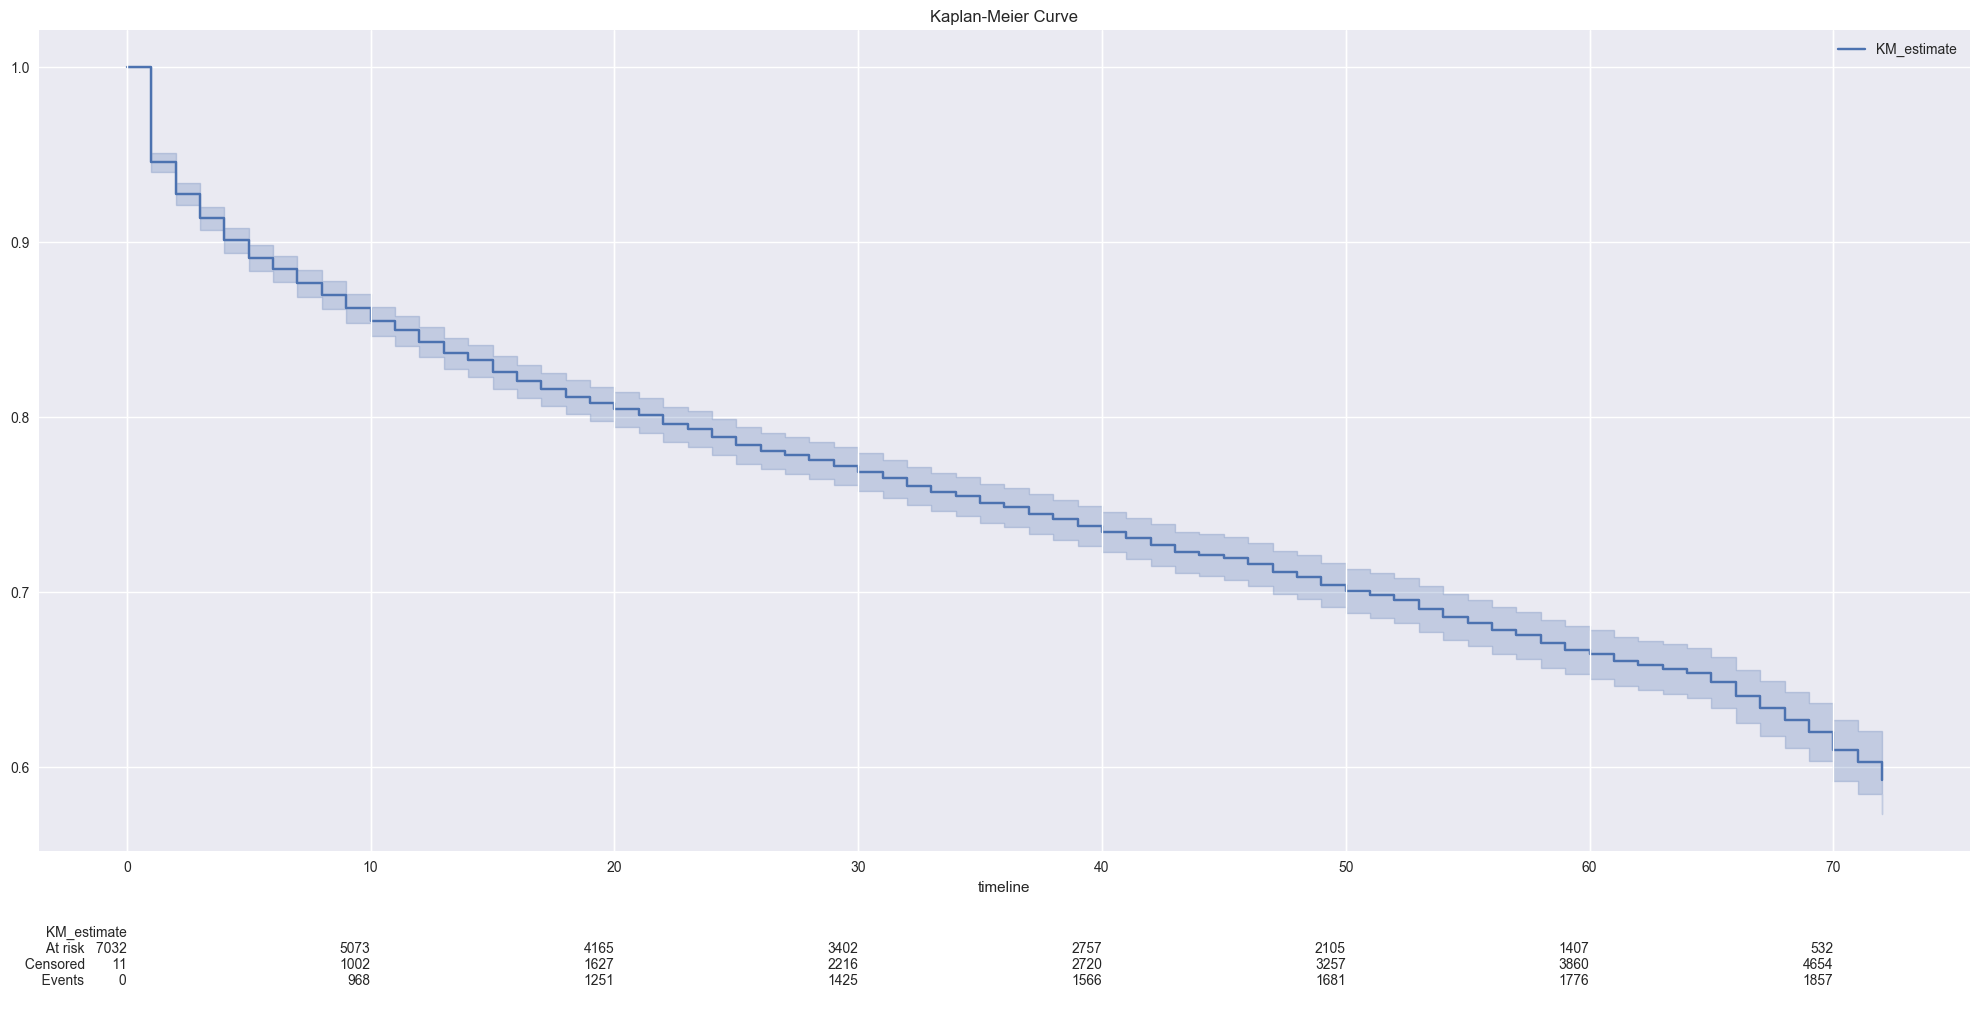

In [5]:
# we only need time-to-event and the churn flag for the basic model

T = df['tenure'] 
E = df['churn']

kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)

kmf.plot(at_risk_counts=True)
plt.title('Kaplan-Meier Curve');

This code calculates and visualizes a Kaplan-Meier survival curve to estimate the probability of remaining a customer (not churning) over time. 

It begins by assigning the ‘tenure’ column from the DataFrame `df` to the variable `T`. This represents the time-to-event, in this case, the length of time a customer remains with the company. The ‘churn’ column is assigned to the variable `E`, representing the event indicator – whether or not a customer churned (1 for churned, 0 for still a customer).

A `KaplanMeierFitter` object is created from the `lifelines` library and then fitted to the data using the `fit()` method. The `T` variable provides the time values, and `event_observed=E` specifies which observations represent events (churns) and which are censored (customers who haven’t churned by the end of the observation period).

The code then generates a Kaplan-Meier plot using the `plot()` method of the fitted `kmf` object. The `at_risk_counts=True` argument adds information to the plot showing the number of customers still at risk of churning at each time point. 

Finally, `plt.title('Kaplan-Meier Curve')` sets the title of the plot to "Kaplan-Meier Curve". This visualization shows the estimated probability of survival (not churning) as a function of time.

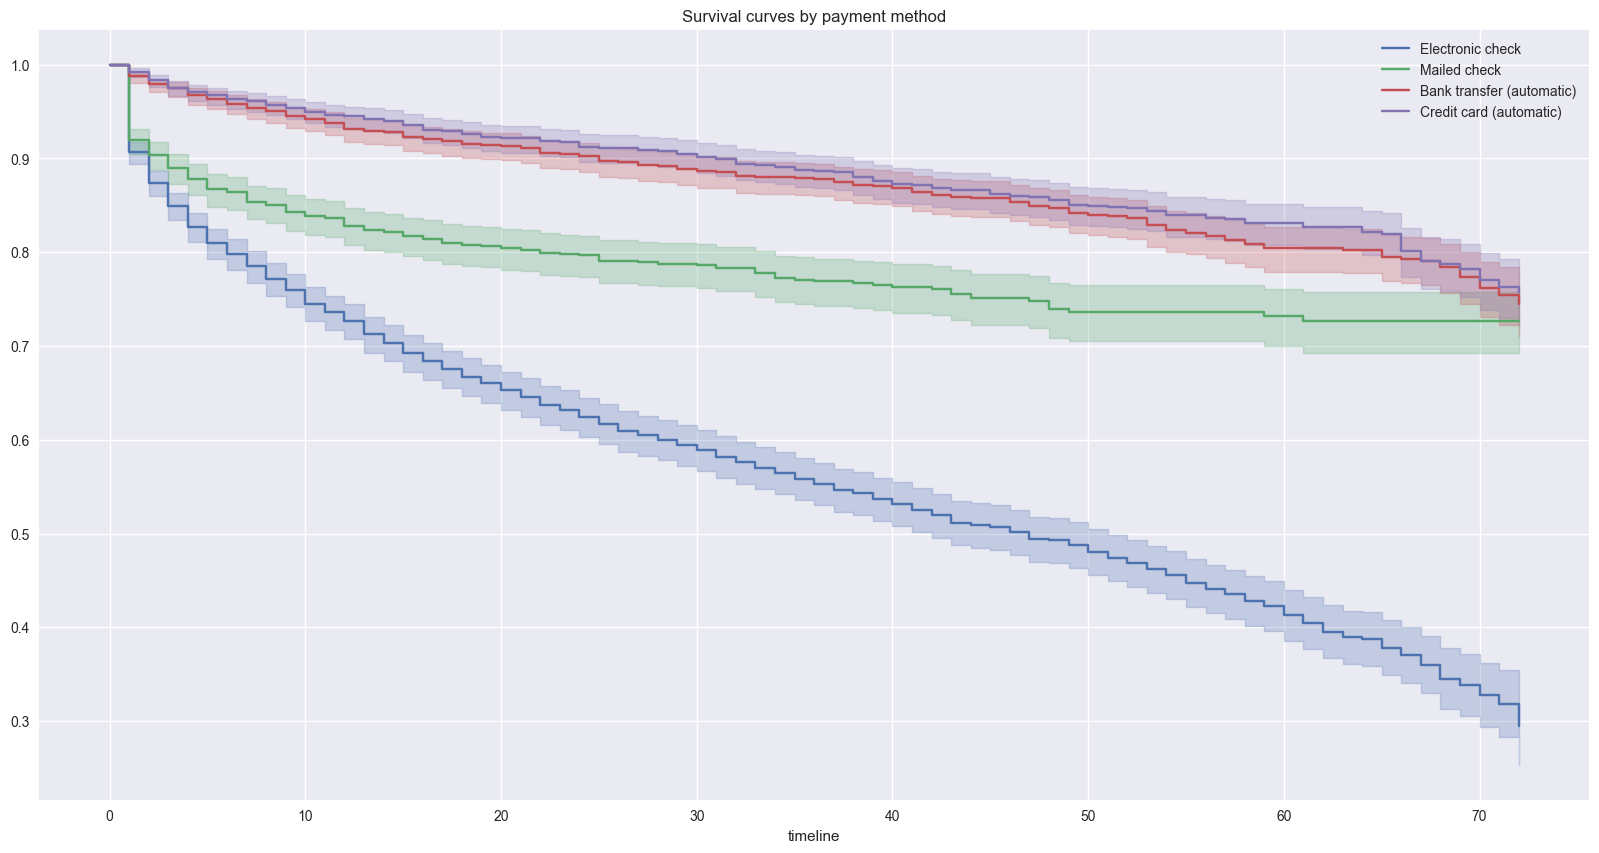

In [6]:
ax = plt.subplot(111)

kmf = KaplanMeierFitter()

for payment_method in df['PaymentMethod'].unique():
    
    flag = df['PaymentMethod'] == payment_method
    
    kmf.fit(T[flag], event_observed = E[flag], label = payment_method)
    kmf.plot(ax=ax)

plt.title("Survival curves by payment method");

This code generates Kaplan-Meier survival curves for different customer segments based on their payment method. 

It first creates a subplot using `plt.subplot(111)`, assigning it to the variable `ax`. This sets up an area within the figure where the plots will be drawn.

A `KaplanMeierFitter` object is initialized. Then, the code iterates through each unique value in the ‘PaymentMethod’ column of the DataFrame `df`. 

Inside the loop, a boolean mask `flag` is created to select rows corresponding to the current payment method being considered. This mask is used to subset both the time-to-event data (`T`) and the event indicator (`E`), ensuring that the Kaplan-Meier curve is calculated only for customers with that specific payment method.

The `kmf.fit()` method is called with the subsetted data, fitting a Kaplan-Meier model to the survival times and event occurrences for the current payment method. The `label` argument sets the label for this curve in the plot legend to the corresponding payment method name. 

Then, `kmf.plot(ax=ax)` plots the fitted Kaplan-Meier curve on the subplot defined by `ax`. This adds a new survival curve to the same plot for each payment method.

Finally, `plt.title("Survival curves by payment method")` sets the title of the entire plot, indicating that it displays survival curves grouped by payment method. The resulting visualization allows comparison of churn rates across different payment methods.

In [7]:

credit_card_flag = df['PaymentMethod'] == 'Credit card (automatic)'
bank_transfer_flag = df['PaymentMethod'] == 'Bank transfer (automatic)'

results = logrank_test(T[credit_card_flag], 
                       T[bank_transfer_flag], 
                       E[credit_card_flag], 
                       E[bank_transfer_flag])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.87 0.35      1.51

This code performs a log-rank test to compare the survival distributions between customers who pay with credit cards and those who use bank transfers.

First, boolean masks `credit_card_flag` and `bank_transfer_flag` are created. These flags identify rows in the DataFrame `df` where the ‘PaymentMethod’ is equal to 'Credit card (automatic)' and 'Bank transfer (automatic)', respectively. 

Next, the `logrank_test` function from the `lifelines.statistics` module is called. It takes four arguments: the time-to-event data for credit card users (`T[credit_card_flag]`), the time-to-event data for bank transfer users (`T[bank_transfer_flag]`), the event indicator (churn status) for credit card users (`E[credit_card_flag]`), and the event indicator for bank transfer users (`E[bank_transfer_flag]`). This function performs a statistical test to determine if there is a significant difference in the survival distributions between these two groups.

The result of the `logrank_test` is stored in the variable `results`. Finally, `results.print_summary()` displays a summary of the log-rank test results, including the test statistic, degrees of freedom, and p-value. The p-value indicates the probability of observing the obtained (or more extreme) results if there were no actual difference between the survival distributions of the two groups; a small p-value suggests that the difference is statistically significant.

In [8]:
results = pairwise_logrank_test(df['tenure'], df['PaymentMethod'], df['churn'])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                                                   test_statistic      p  -log2(p)
Bank transfer (automatic) Credit card (automatic)            0.87   0.35      1.51
                          Electronic check                 510.04 <0.005    372.74
                          Mailed check                      51.07 <0.005     40.03
Credit card (automatic)   Electronic check                 539.74 <0.005    394.21
                          Mailed check                      64.82 <0.005     50.11
Electronic check          Mailed check                     152.46 <0.005    113.93

This code conducts multiple log-rank tests to compare survival distributions across all unique payment methods within the dataset.

The `pairwise_logrank_test` function from the `lifelines.statistics` module is called with three arguments: `df['tenure']` (the time-to-event data), `df['PaymentMethod']` (a series containing the different payment method categories), and `df['churn']` (the event indicator). This function automatically performs log-rank tests for every possible pair of unique values in the ‘PaymentMethod’ column. 

The results of all these pairwise comparisons are stored in the variable `results`.  Then, `results.print_summary()` displays a summary table containing the results of each individual log-rank test, including the test statistic, p-value, and adjusted p-values (to account for multiple testing). This allows for identifying which pairs of payment methods have significantly different survival distributions (churn rates).

Text(0.5, 1.0, 'Cumulative hazard function')

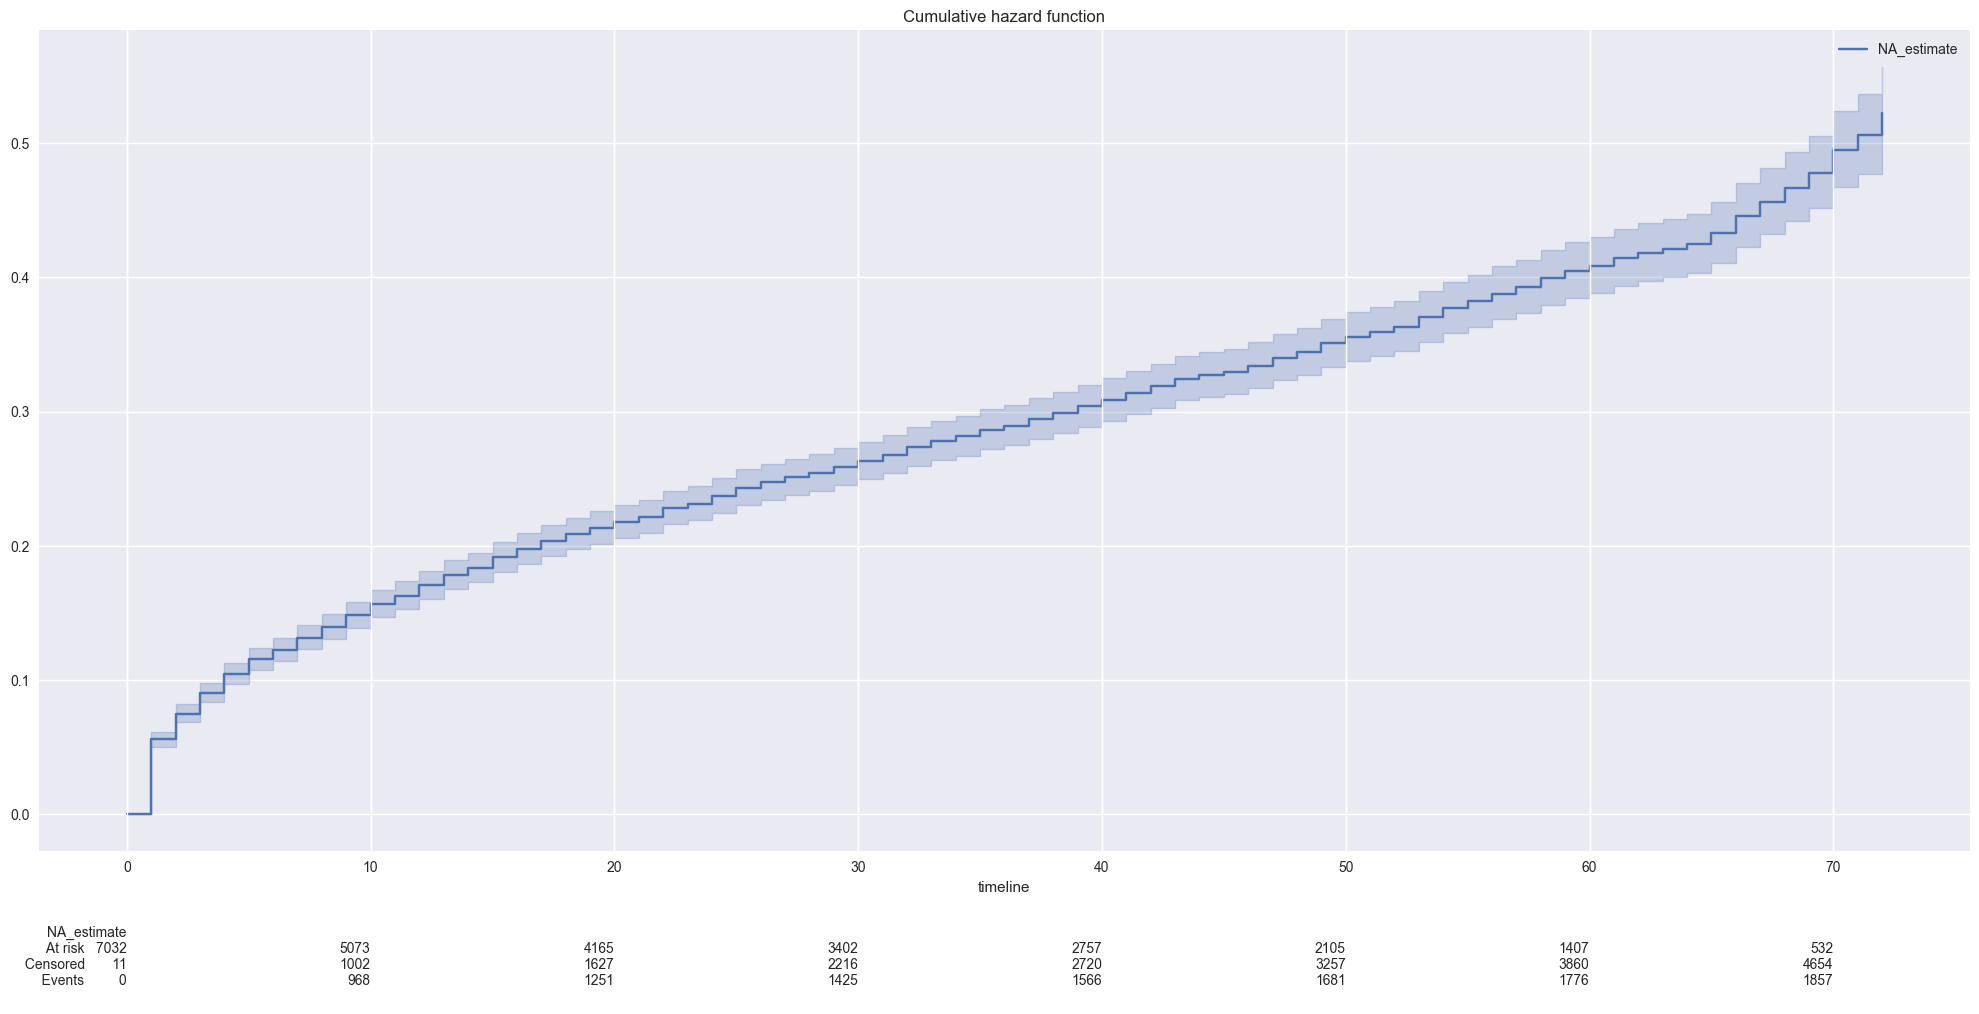

In [9]:
naf = NelsonAalenFitter()
naf.fit(T, event_observed=E)

naf.plot(at_risk_counts=True)
plt.title('Cumulative hazard function')

This code calculates and visualizes the cumulative hazard function to understand the risk of churn accumulating over time. 

It begins by creating a `NelsonAalenFitter` object from the `lifelines` library. This object is then fitted to the data using the `fit()` method, with `T` representing the time-to-event (tenure) and `E` indicating whether an event occurred (churned).

The code then generates a plot of the cumulative hazard function using the `plot()` method of the fitted `naf` object. The `at_risk_counts=True` argument adds information to the plot showing the number of customers still at risk at each time point. 

Finally, `plt.title('Cumulative hazard function')` sets the title of the plot to "Cumulative hazard function". This visualization shows how the instantaneous risk of churn changes over time; a steeper slope indicates a higher risk of churning at that time point.

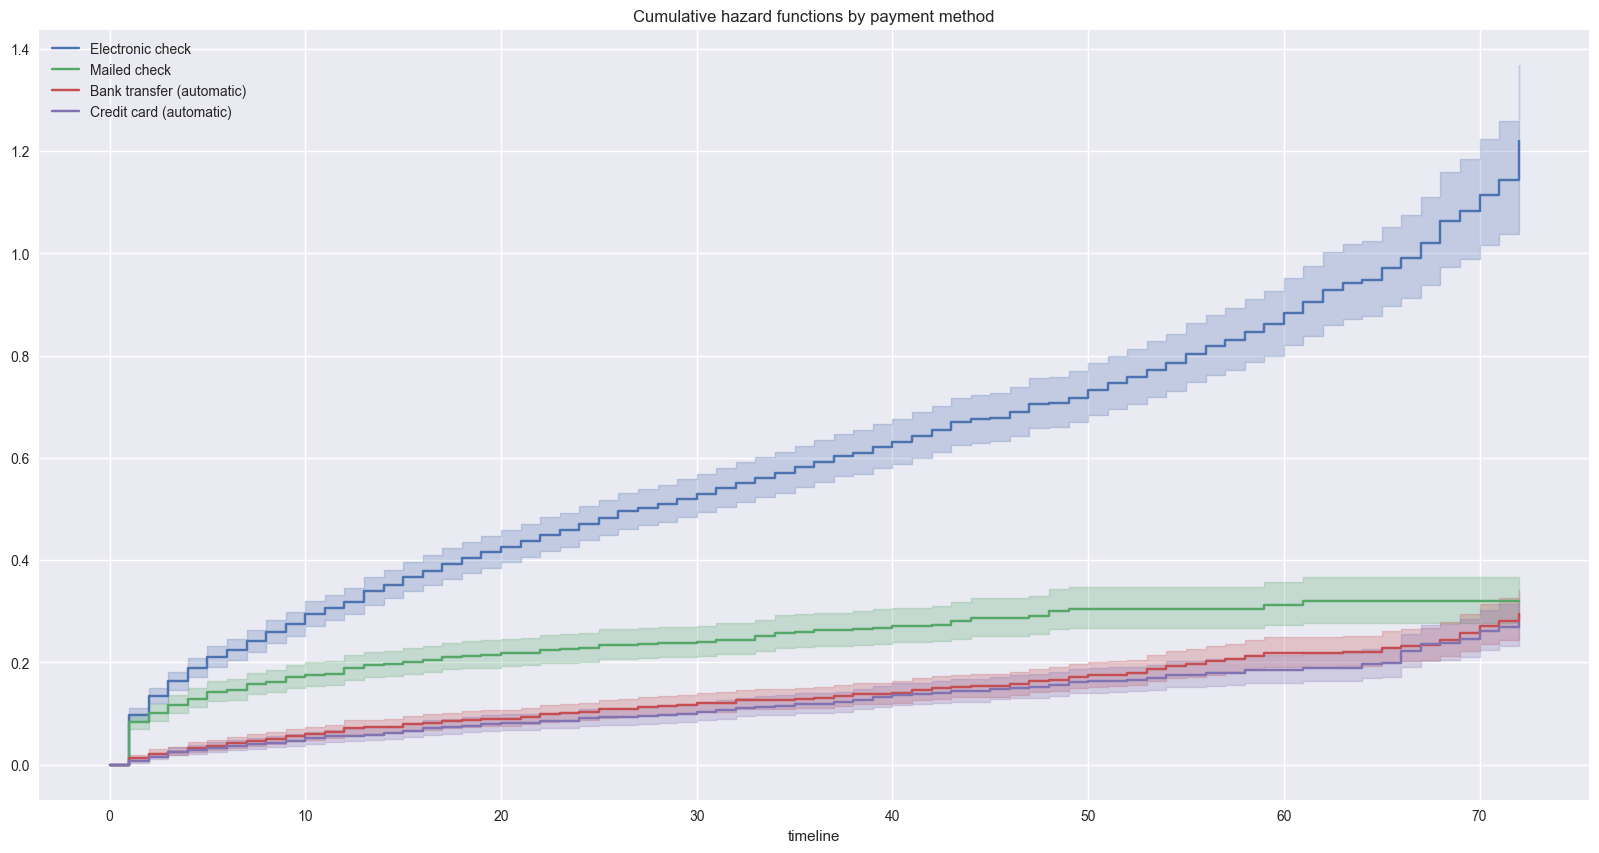

In [10]:
ax = plt.subplot(111)

naf = NelsonAalenFitter()

for payment_method in df['PaymentMethod'].unique():
    
    flag = df['PaymentMethod'] == payment_method
    
    naf.fit(T[flag], event_observed=E[flag], label=payment_method)
    naf.plot(ax=ax)

plt.title('Cumulative hazard functions by payment method');

This code generates cumulative hazard function plots for different customer segments based on their payment method, allowing comparison of churn risk accumulation across these groups. 

It first creates a subplot using `plt.subplot(111)`, assigning it to the variable `ax`. This sets up an area within the figure where the plots will be drawn.

A `NelsonAalenFitter` object is initialized. The code then iterates through each unique value in the ‘PaymentMethod’ column of the DataFrame `df`. 

Inside the loop, a boolean mask `flag` is created to select rows corresponding to the current payment method being considered. This mask is used to subset both the time-to-event data (`T`) and the event indicator (`E`), ensuring that the cumulative hazard function is calculated only for customers with that specific payment method.

The `naf.fit()` method is called with the subsetted data, fitting a Nelson-Aalen model to the survival times and event occurrences for the current payment method. The `label` argument sets the label for this curve in the plot legend to the corresponding payment method name. 

Then, `naf.plot(ax=ax)` plots the fitted cumulative hazard function on the subplot defined by `ax`. This adds a new curve to the same plot for each payment method.

Finally, `plt.title('Cumulative hazard functions by payment method')` sets the title of the entire plot, indicating that it displays cumulative hazard functions grouped by payment method. The resulting visualization allows comparison of how churn risk accumulates over time for different payment methods.

# Cox regression

In [11]:
# process the data for Cox model
id_col = df['customerID']; df.drop(['customerID', 'TotalCharges'], axis = 1, inplace = True)
df = df[['gender', 'SeniorCitizen', 'Partner','tenure', 'churn', 'PhoneService', 'OnlineSecurity', 'Contract']]
df = pd.get_dummies(df, drop_first = True)

# split into training and test
df_train, df_test =  df.iloc[:-10], df.iloc[-10:]


cph = CoxPHFitter()

cph.fit(df_train, duration_col='tenure', event_col='churn')

<lifelines.CoxPHFitter: fitted with 7033 total observations, 5166 right-censored observations>

This code prepares the data for a Cox proportional hazards model and then fits the model to the training data. 

First, it identifies the ‘customerID’ column and stores it in `id_col`. Then, it removes both the ‘customerID’ and ‘TotalCharges’ columns from the DataFrame `df` using `df.drop()`, modifying the DataFrame directly with `inplace=True`.

Next, it selects a subset of columns from `df`: 'gender', 'SeniorCitizen', 'Partner', 'tenure', 'churn', 'PhoneService', 'OnlineSecurity', and ‘Contract’. These are the features that will be used in the Cox model. 

The code then converts categorical variables into numerical dummy variables using `pd.get_dummies()`. The `drop_first=True` argument prevents multicollinearity by dropping the first category for each categorical feature, as it can be inferred from the other categories.

The DataFrame is split into training and testing sets.  `df_train` contains all rows except the last 10, while `df_test` contains only the last 10 rows. This creates a small test set for evaluating model performance later.

Finally, a `CoxPHFitter` object is created from the `lifelines` library. The `fit()` method is called to fit the Cox proportional hazards model to the training data (`df_train`).  The `duration_col='tenure'` argument specifies that the ‘tenure’ column represents the time-to-event, and `event_col='churn'` indicates that the ‘churn’ column represents the event indicator. The fitted model now contains information about the relationship between the features and the hazard of churn.

In [12]:
cph.print_summary(columns=["coef","exp(coef)","exp(coef) lower 95%","exp(coef) upper 95%", "z", "p"], decimals=3)


<lifelines.CoxPHFitter: fitted with 7033 total observations, 5166 right-censored observations>
             duration col = 'tenure'
                event col = 'churn'
      baseline estimation = breslow
   number of observations = 7033
number of events observed = 1867
   partial log-likelihood = -14141.867
         time fit was run = 2026-02-03 10:23:37 UTC

---
                                     coef exp(coef) exp(coef) lower 95% exp(coef) upper 95%       z       p
covariate                                                                                                  
SeniorCitizen                      -0.034     0.966               0.869               1.075  -0.633   0.527
gender_Male                        -0.056     0.945               0.863               1.035  -1.218   0.223
Partner_Yes                        -0.615     0.541               0.490               0.596 -12.341 <0.0005
PhoneService_Yes                    0.169     1.184               1.011               1.388   2.092   0.036
OnlineSecurity_No internet service -0.747     0.474               0.389               0.577  -7.411 <0.0005
OnlineSecurity_Yes                 -0.786     0.456               0.401               0.518 -12.026 <0.0005
Contract_One year                  -1.966     0.140               0.118               0.165 -23.072 <0.0005
Contract_Two year                  -3.774     0.023               0.017               0.031 -23.470 <0.0005
---
Concordance = 0.829
Partial AIC = 28299.733
log-likelihood ratio test = 2985.035 on 8 df
-log2(p) of ll-ratio test = inf

This code displays a summary of the fitted Cox proportional hazards model, focusing on key coefficients and their statistical significance.

The `cph.print_summary()` method is called to generate a table summarizing the results of the Cox model fit. The `columns` argument specifies which columns from the model's output should be included in the summary: 
*   "coef": The estimated coefficient for each feature.
*   "exp(coef)": The hazard ratio associated with each feature (the exponentiated coefficient).
*   "exp(coef) lower 95%": The lower bound of the 95% confidence interval for the hazard ratio.
*   "exp(coef) upper 95%": The upper bound of the 95% confidence interval for the hazard ratio.
*   "z": The z-statistic for each coefficient, testing its significance.
*   "p": The p-value associated with each coefficient, indicating the probability of observing the estimated effect if there were no true association between the feature and the hazard rate.

The `decimals=3` argument formats the numerical values in the summary table to three decimal places for improved readability. 

This output provides insights into which features are significantly associated with churn risk (based on the p-values) and the direction and magnitude of their effects (indicated by the coefficients and hazard ratios).

<Axes: xlabel='log(HR) (95% CI)'>

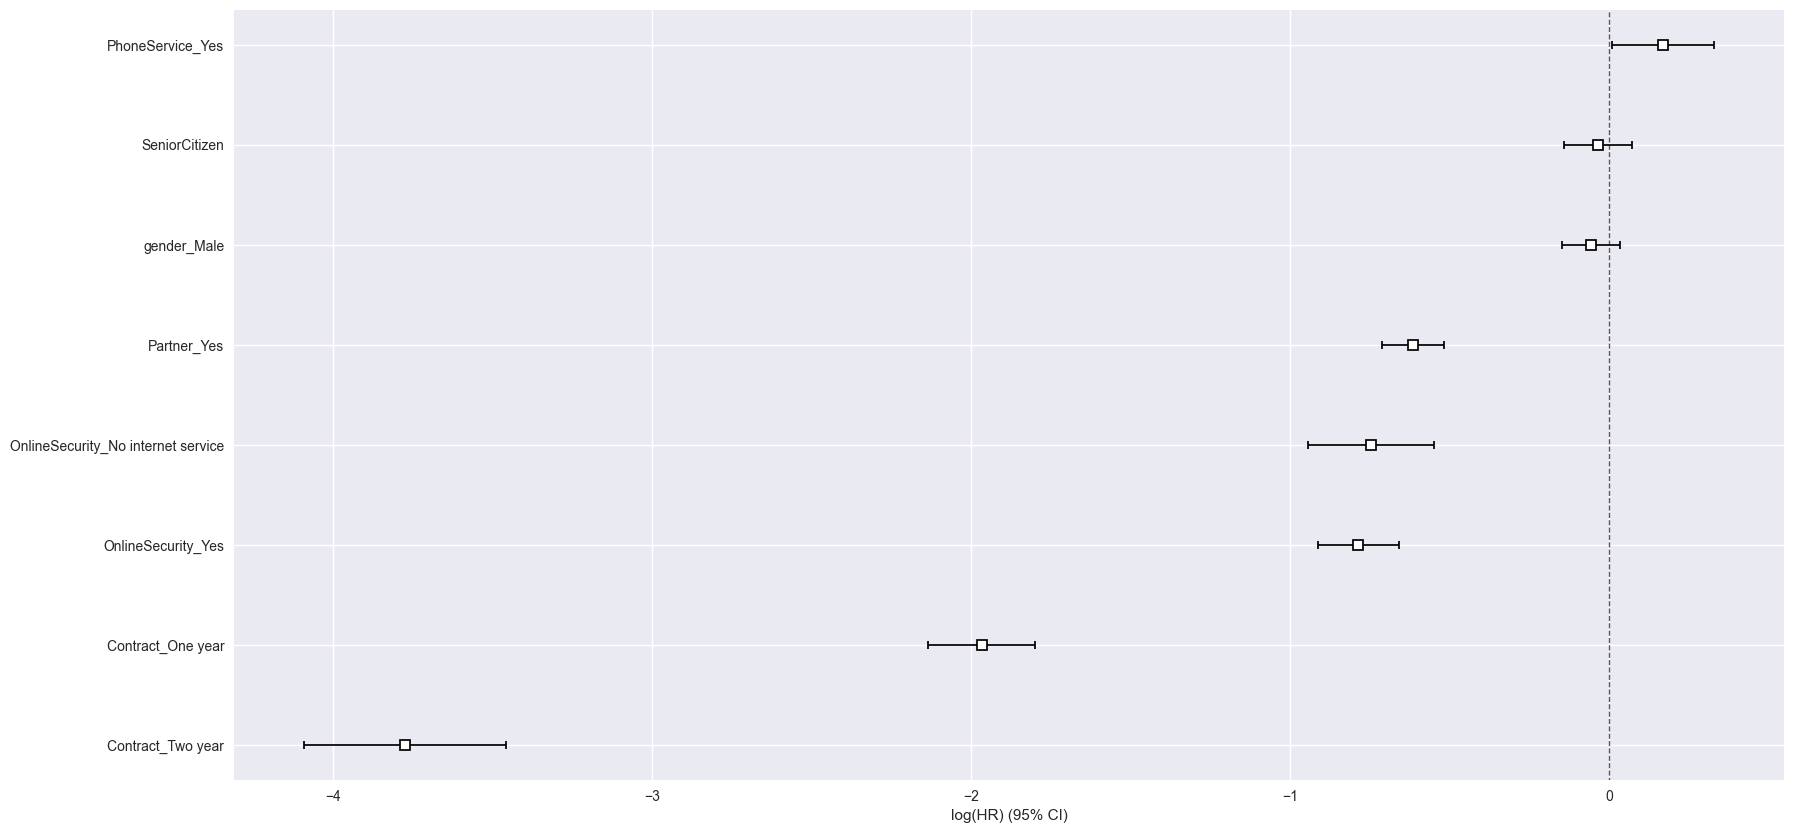

In [13]:
cph.plot()

This code generates a plot visualizing the estimated coefficients from the fitted Cox proportional hazards model.

The `cph.plot()` method is called on the fitted `CoxPHFitter` object (`cph`). This creates a plot where each feature included in the model is represented along the x-axis, and its corresponding coefficient (from the Cox model) is plotted on the y-axis. 

Error bars are typically included in the plot to represent the confidence intervals for each coefficient. The plot allows for a quick visual assessment of which features have the largest effects on the hazard rate and whether those effects are statistically significant (based on the error bar positions).

In [14]:
cph.predict_survival_function(df_test)

,7033,7034,7035,7036,7037,7038,7039,7040,7041,7042
0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1.0,0.873556,0.936883,0.873556,0.983238,0.998446,0.995348,0.989235,0.970676,0.931816,0.998586
2.0,0.828889,0.913465,0.828889,0.976805,0.997843,0.993548,0.985087,0.959523,0.906614,0.998038
3.0,0.793657,0.894529,0.793657,0.971514,0.997344,0.992060,0.981667,0.950391,0.886274,0.997584
4.0,0.762054,0.877169,0.762054,0.966590,0.996878,0.990671,0.978478,0.941926,0.867659,0.997160
...,...,...,...,...,...,...,...,...,...,...
68.0,0.029101,0.181620,0.029101,0.642557,0.960121,0.885149,0.753378,0.458987,0.157595,0.963662
69.0,0.018944,0.147654,0.018944,0.608972,0.955390,0.872138,0.727923,0.417591,0.125934,0.959343
70.0,0.008402,0.099758,0.008402,0.550100,0.946494,0.848020,0.682047,0.349148,0.082354,0.951215
71.0,0.004505,0.073856,0.004505,0.508849,0.939730,0.829981,0.648844,0.304374,0.059465,0.945030


This code calculates the predicted survival function for each individual in the test dataset using the fitted Cox proportional hazards model.

The `cph.predict_survival_function()` method is called with `df_test` as its argument. This method uses the coefficients estimated during the model fitting process to predict the survival probability over time for each row (customer) in the test DataFrame (`df_test`). 

The output of this function is a Pandas DataFrame where each row corresponds to an individual in the test set, and each column represents the predicted survival probability at a specific time point. This allows you to assess how well the model predicts the likelihood of remaining a customer (not churning) over time for individuals in the test dataset.

<Axes: >

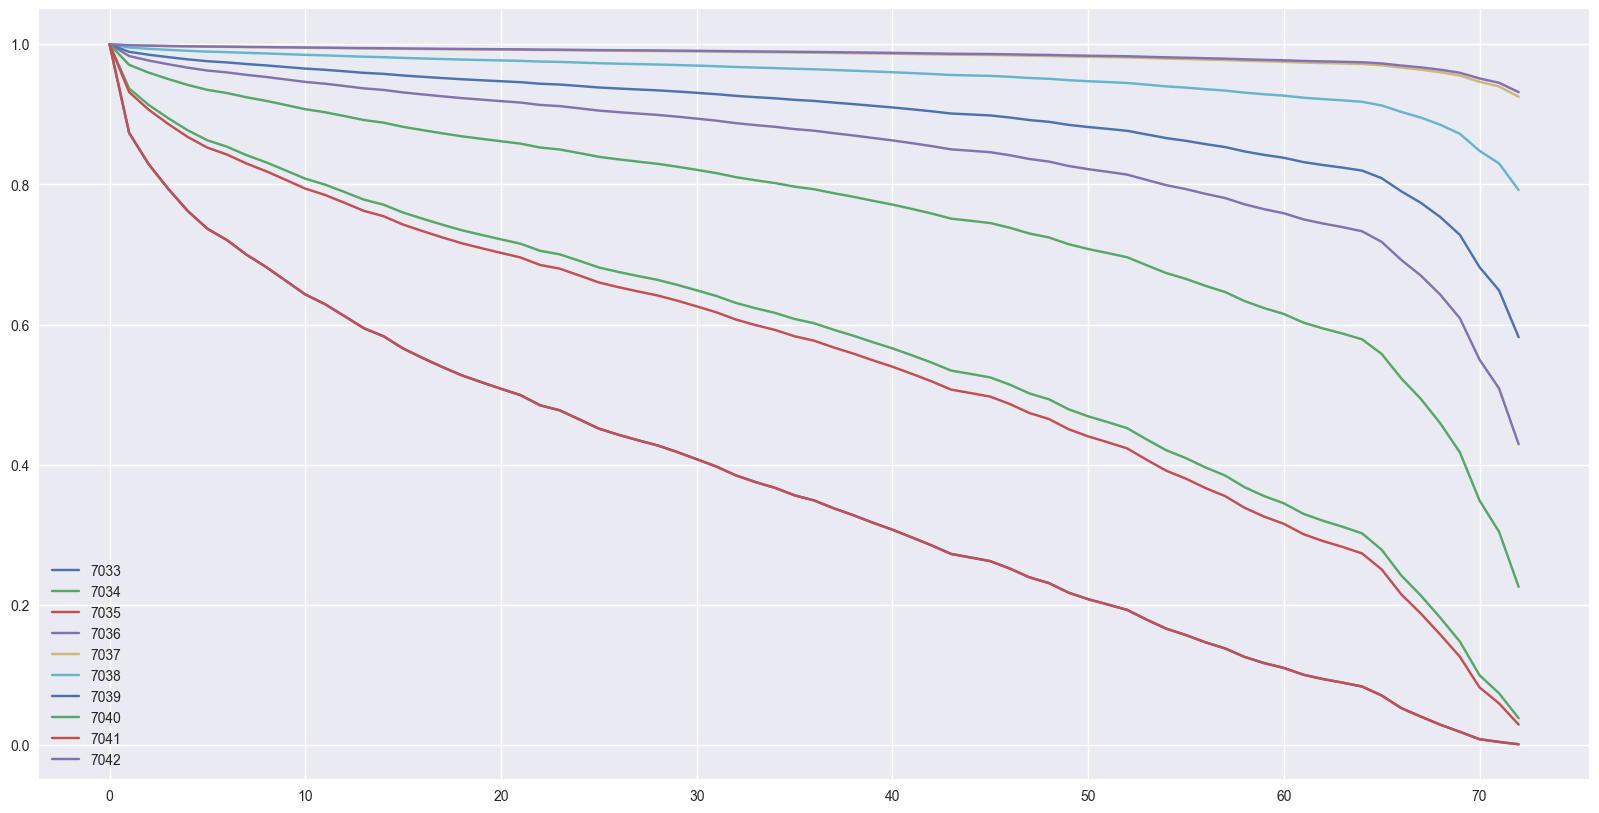

In [15]:
cph.predict_survival_function(df_test).plot()

This code visualizes the predicted survival functions for each individual in the test dataset.

The `cph.predict_survival_function(df_test)` part, as before, calculates the predicted survival probabilities over time for each customer in the test set (`df_test`). The `.plot()` method is then chained to this result. This instructs Pandas to create a plot directly from the DataFrame of predicted survival functions.

Each line on the resulting plot represents the predicted survival curve for a single customer in the test dataset. The x-axis typically represents time (tenure), and the y-axis represents the predicted probability of survival (not churning). This visualization allows you to see how the model predicts different churn risks for individual customers based on their characteristics.

<Axes: >

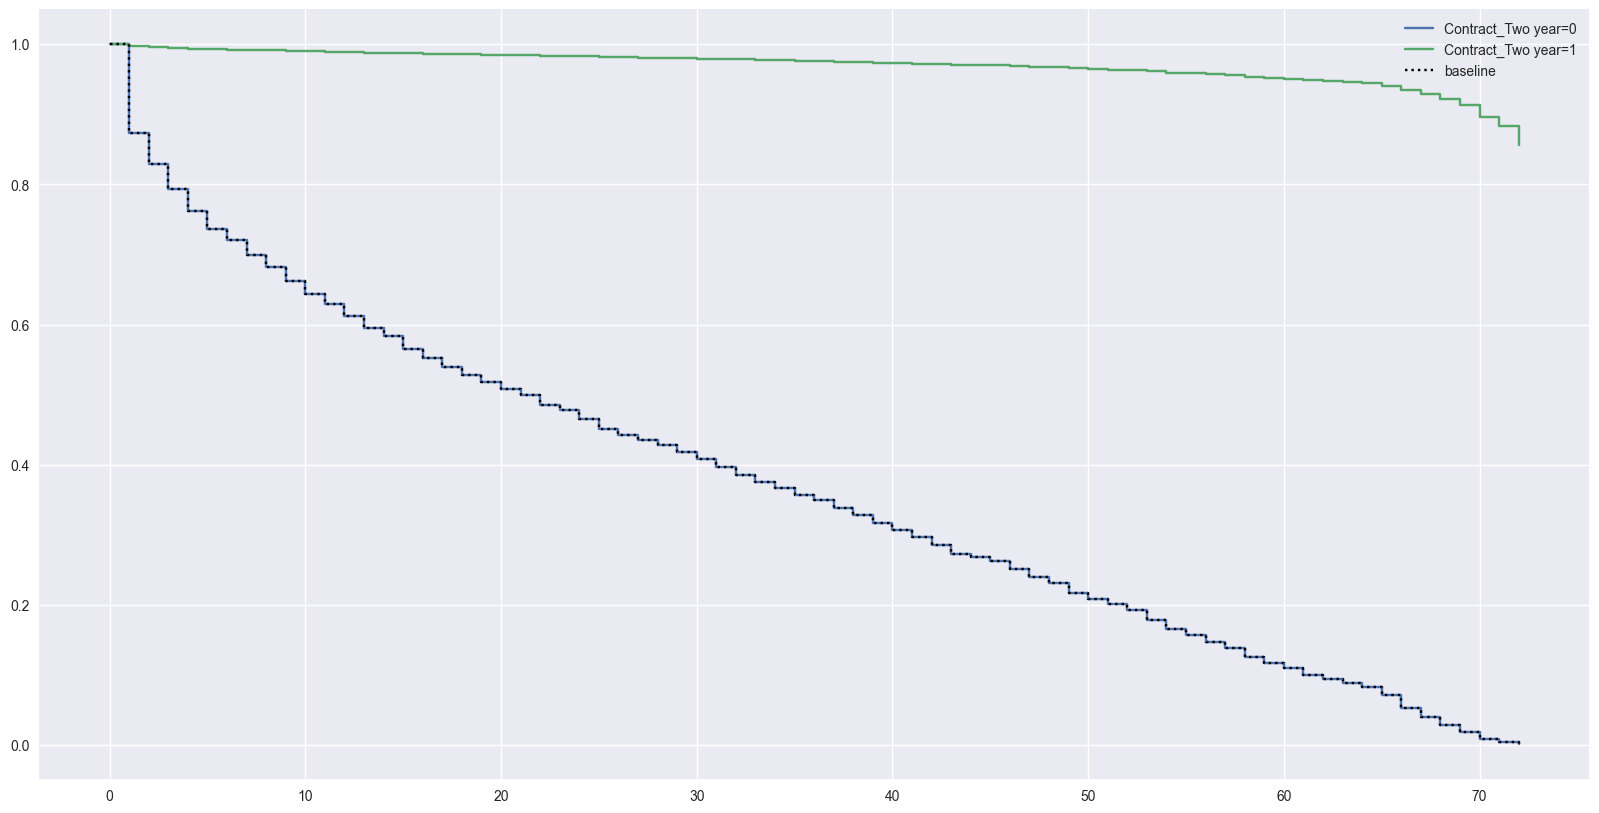

In [16]:
cph.plot_partial_effects_on_outcome(covariates='Contract_Two year', values = [0,1])


This code generates a plot illustrating the partial effect of the ‘Contract_Two year’ variable on the predicted hazard rate.

The `cph.plot_partial_effects_on_outcome()` method is called with two arguments: `covariates='Contract_Two year'` specifies that we want to examine the effect of the 'Contract_Two year' dummy variable, and `values = [0,1]` indicates that the plot should show the predicted hazard rate for both cases where this variable is 0 (representing a contract length other than two years) and where it is 1 (representing a two-year contract).

The resulting plot displays how the predicted hazard rate changes as the value of ‘Contract_Two year’ varies, holding all other variables constant at their average values. This allows you to visually assess whether having a two-year contract increases or decreases the risk of churn compared to other contract lengths. The plot typically shows curves representing the predicted hazard rates for each value of the covariate (0 and 1 in this case), along with confidence intervals to indicate the uncertainty in these estimates.

# Survival forest

In [17]:

time_column = 'tenure'
event_column = 'churn'

features = [f for f in df.columns if f not in ['tenure', 'churn']]


df_train, df_test =  df.iloc[:-10], df.iloc[-10:]


X = df.drop(columns=[time_column, event_column])
y = Surv.from_dataframe(time = time_column, event = event_column, data = df)


X_train = X.iloc[:-10]
X_test = X.iloc[-10:]
y_train = y[:-10]
y_test = y[-10:]

This code prepares the data for use with scikit-survival, splitting it into training and testing sets and formatting it appropriately for model fitting.

First, it defines variables `time_column` and `event_column` to store the names of the columns representing time-to-event and event status (churn), respectively. 

Next, a list called `features` is created using a list comprehension. This list contains all column names from the DataFrame `df` except for ‘tenure’ and ‘churn’, effectively selecting the features that will be used to predict churn.

The code then splits the DataFrame into training (`df_train`) and testing (`df_test`) sets, similar to previous steps: `df_train` contains all rows except the last 10, and `df_test` contains only the last 10 rows.

It creates separate DataFrames for features (X) and survival data (y).  `X` is created by dropping the ‘tenure’ and ‘churn’ columns from the original DataFrame `df`. The `Surv.from_dataframe()` function from scikit-survival is used to create a `Surv` object (`y`) representing the time-to-event data with censoring information. It takes the `time_column` and `event_column` as arguments, along with the entire DataFrame `df`.

Finally, it splits both the feature matrix (X) and the survival object (y) into training and testing sets, mirroring the split applied to the original DataFrame. This ensures that the model is trained on one set of data and evaluated on a separate, unseen set.

In [18]:
rsf = RandomSurvivalForest(
    n_estimators=300,
    min_samples_split=10,
    min_samples_leaf=15,
    n_jobs=-1,
    random_state=42
)
rsf.fit(X_train, y_train)

,n_estimators,300
,max_depth,None
,min_samples_split,10
,min_samples_leaf,15
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,bootstrap,True
,oob_score,False
,n_jobs,-1
,random_state,42


This code trains a Random Survival Forest model using the prepared training data.

A `RandomSurvivalForest` object is created from the `sksurv.ensemble` module. Several hyperparameters are specified during initialization: 
*   `n_estimators=300`: Sets the number of trees in the forest to 300.
*   `min_samples_split=10`: Specifies that a node must contain at least 10 samples before it can be split further.
*   `min_samples_leaf=15`:  Specifies that each leaf node must contain at least 15 samples.
*   `n_jobs=-1`: Utilizes all available CPU cores for parallel processing, speeding up the training process.
*   `random_state=42`: Sets a random seed for reproducibility, ensuring consistent results across multiple runs.

The `fit()` method is then called on the `rsf` object, passing in the training features (`X_train`) and the corresponding survival data (`y_train`). This trains the Random Survival Forest model by building an ensemble of decision trees based on the training data. The trained model now contains information about the relationships between the features and the time-to-event outcome (churn).

In [19]:
# Risk scores (for C-index)
risk_scores = rsf.predict(X_test)

cindex = concordance_index_censored(
    y_test[event_column],
    y_test[time_column],
    risk_scores
)[0]

print("C-index:", round(cindex, 4))

# IBS
# Extract event times only (required by sksurv)
event_times = y_test[time_column][y_test[event_column] == 1]

times = np.linspace(
    event_times.min(),
    event_times.max(),
    100
)


surv_fns = rsf.predict_survival_function(X_test)
surv_preds = np.vstack([fn(times) for fn in surv_fns])

ibs = integrated_brier_score(
    y_train,
    y_test,
    surv_preds,
    times
)

print("IBS:", round(ibs, 4))


C-index: 0.8182
IBS: 0.1116


This code evaluates the performance of the trained Random Survival Forest model using two metrics: the C-index and the Integrated Brier Score (IBS).

First, it calculates risk scores for the test data using `rsf.predict(X_test)`. These risk scores represent the model's prediction of the hazard rate for each individual in the test set. 

The C-index is then computed using the `concordance_index_censored` function from `scikit-survival.metrics`, similar to previous calculations. It takes the event status (`y_test[event_column]`), observed times (`y_test[time_column]`), and predicted risk scores as input. The `[0]` extracts the C-index value, which is then printed, rounded to four decimal places.

Next, the code calculates the Integrated Brier Score (IBS), another metric for evaluating survival prediction models. It first extracts the event times from the test set where an event occurred (`event_times = y_test[time_column][y_test[event_column] == 1]`). Then it creates a series of time points at which to evaluate the predicted survival functions using `np.linspace`.

The code then uses `rsf.predict_survival_function(X_test)` to obtain the predicted survival function for each individual in the test set. It evaluates these survival functions at the specified time points (`times`) and stacks the results into a NumPy array called `surv_preds`. 

Finally, it calculates the IBS using the `integrated_brier_score` function from `scikit-survival.metrics`, providing the training data (`y_train`), test data (`y_test`), predicted survival probabilities (`surv_preds`), and time points (`times`) as input. The calculated IBS is then printed, rounded to four decimal places. A lower IBS indicates better calibration of the model's predictions.

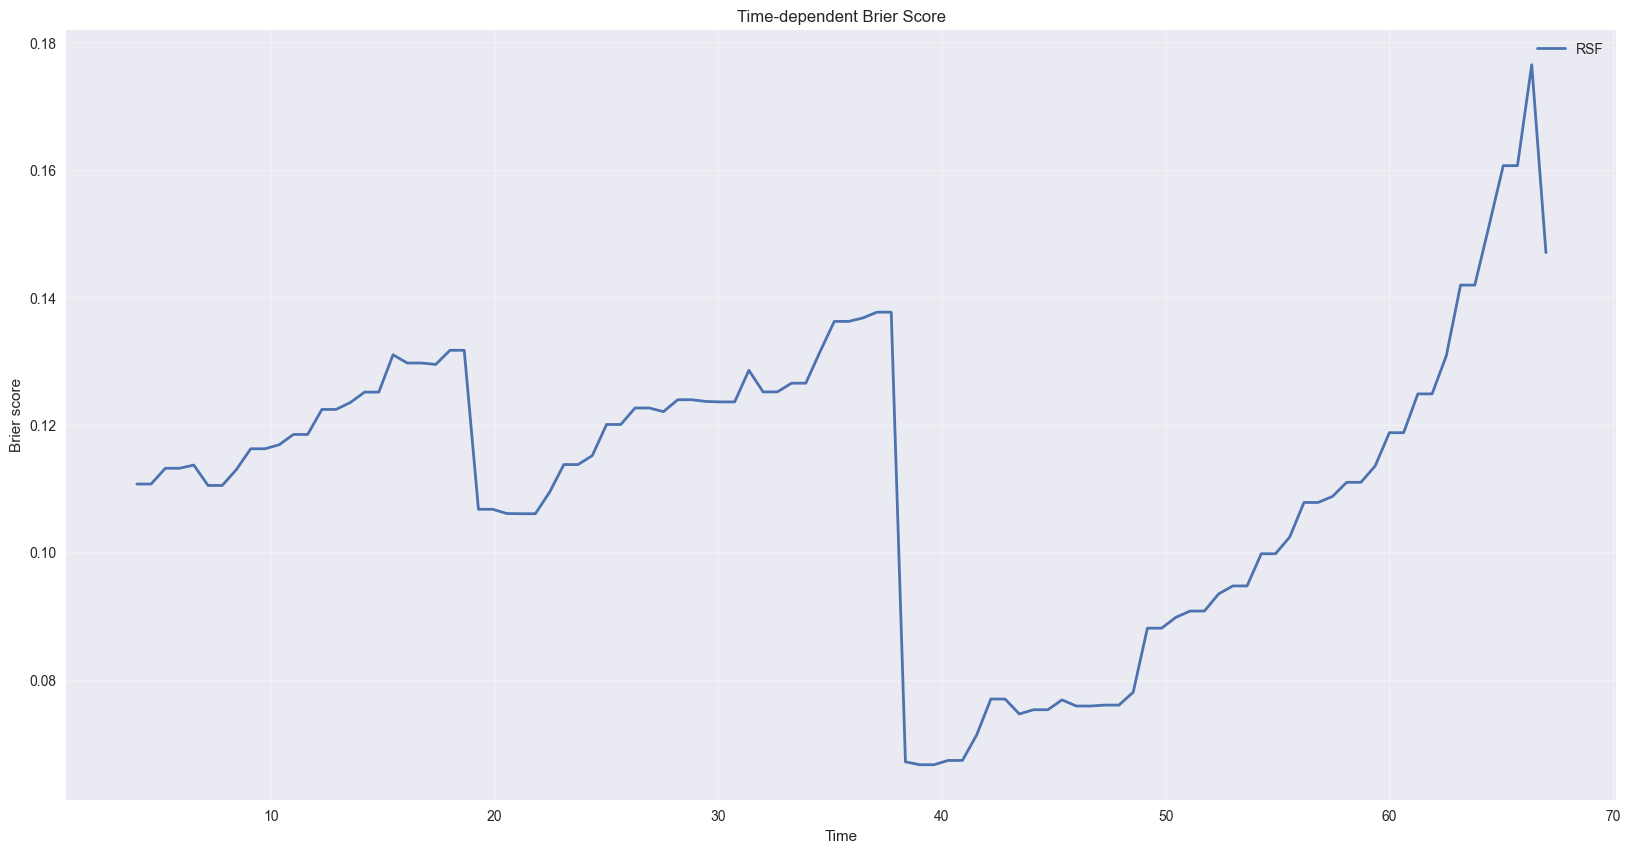

In [20]:

# RSF survival predictions
surv_fns_rsf = rsf.predict_survival_function(X_test)
surv_preds_rsf = np.vstack([fn(times) for fn in surv_fns_rsf])

# Brier score over time
times_bs, brier_rsf = brier_score(
    y_train,
    y_test,
    surv_preds_rsf,
    times
)

# Plot
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
plt.plot(times_bs, brier_rsf, label="RSF", linewidth=2)
plt.xlabel("Time")
plt.ylabel("Brier score")
plt.title("Time-dependent Brier Score")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

This code calculates and visualizes the time-dependent Brier score for the Random Survival Forest model, providing insights into its calibration over time.

First, it predicts survival functions for the test data using `rsf.predict_survival_function(X_test)`, storing them in `surv_fns_rsf`. It then evaluates these survival functions at a series of predefined time points (`times`) and stacks the results into a NumPy array called `surv_preds_rsf`, similar to the IBS calculation.

Next, it calculates the Brier score as a function of time using the `brier_score` function from `scikit-survival.metrics`. This function takes the training data (`y_train`), test data (`y_test`), predicted survival probabilities (`surv_preds_rsf`), and time points (`times`) as input. It returns two arrays: `times_bs` (the time points at which the Brier score was calculated) and `brier_rsf` (the corresponding Brier scores).

Finally, it generates a plot to visualize the time-dependent Brier score. A figure with dimensions specified by `CFG.img_dim1` and `CFG.img_dim2` is created. The code then plots the `times_bs` on the x-axis and the corresponding `brier_rsf` values on the y-axis, labeling the line "RSF" with a linewidth of 2.  The plot includes labels for the x and y axes ("Time" and "Brier score", respectively), a title ("Time-dependent Brier Score"), a legend, and a grid for improved readability. The `plt.show()` command displays the generated plot. This visualization helps assess how well the model's predictions are calibrated at different time points; lower Brier scores indicate better calibration.

In [21]:
cox = CoxPHSurvivalAnalysis()
cox.fit(X_train, y_train)

# RSF
risk_rsf = rsf.predict(X_test)
cindex_rsf = compute_cindex(risk_rsf, y_test, event_column, time_column)

# Cox
risk_cox = -cox.predict(X_test)  # minus sign = higher risk earlier
cindex_cox = compute_cindex(risk_cox, y_test, event_column, time_column)

print(f"C-index RSF : {cindex_rsf:.3f}")
print(f"C-index Cox : {cindex_cox:.3f}")

C-index RSF : 0.818
C-index Cox : 0.182


This code compares the performance of the Random Survival Forest (RSF) and Cox Proportional Hazards models using the C-index metric.

First, a `CoxPHSurvivalAnalysis` object is created from `scikit-survival`. The model is then fitted to the training data (`X_train`, `y_train`) using the `fit()` method.

Next, it calculates the C-index for the RSF model. It predicts risk scores for the test data using `rsf.predict(X_test)`, and then calls the previously defined `compute_cindex` function with these risk scores, along with the test data (`y_test`), event column name, and time column name. The resulting C-index is stored in `cindex_rsf`.

Then, it calculates the C-index for the Cox model. It predicts risk scores using `cox.predict(X_test)`. Importantly, a negative sign is applied to these predictions (`risk_cox = -cox.predict(X_test)`). This is done because the Cox model outputs hazard ratios; higher values indicate lower risk (longer survival time), while lower values indicate higher risk. By negating the predicted values, we align the interpretation with the RSF model where higher scores represent higher risk. The `compute_cindex` function is then called with these adjusted risk scores to calculate `cindex_cox`.

Finally, it prints the C-indices for both models, formatted to three decimal places using f-strings. This allows for a direct comparison of the predictive performance of the RSF and Cox models on the test data.

In [22]:
# Cox survival predictions
surv_fns_cox = cox.predict_survival_function(X_test)
surv_preds_cox = np.vstack([fn(times) for fn in surv_fns_cox])

ibs_rsf = integrated_brier_score(
    y_train, y_test, surv_preds_rsf, times
)

ibs_cox = integrated_brier_score(
    y_train, y_test, surv_preds_cox, times
)

print(f"IBS RSF : {ibs_rsf:.4f}")
print(f"IBS Cox : {ibs_cox:.4f}")

IBS RSF : 0.1116
IBS Cox : 0.1166


This code calculates and compares the Integrated Brier Score (IBS) for both the Random Survival Forest (RSF) and Cox Proportional Hazards models.

First, it predicts survival functions for the test data using `cox.predict_survival_function(X_test)`, storing them in `surv_fns_cox`. It then evaluates these survival functions at a series of predefined time points (`times`) and stacks the results into a NumPy array called `surv_preds_cox`, similar to previous calculations.

Next, it calculates the IBS for both models using the `integrated_brier_score` function from `scikit-survival.metrics`. It calls the function twice: once with the RSF predictions (`surv_preds_rsf`) and once with the Cox predictions (`surv_preds_cox`). The training data (`y_train`), test data (`y_test`), and time points (`times`) are provided as input to both calls.

Finally, it prints the calculated IBS values for both models, formatted to four decimal places using f-strings. This allows for a direct comparison of the calibration performance of the RSF and Cox models; lower IBS values indicate better calibration.

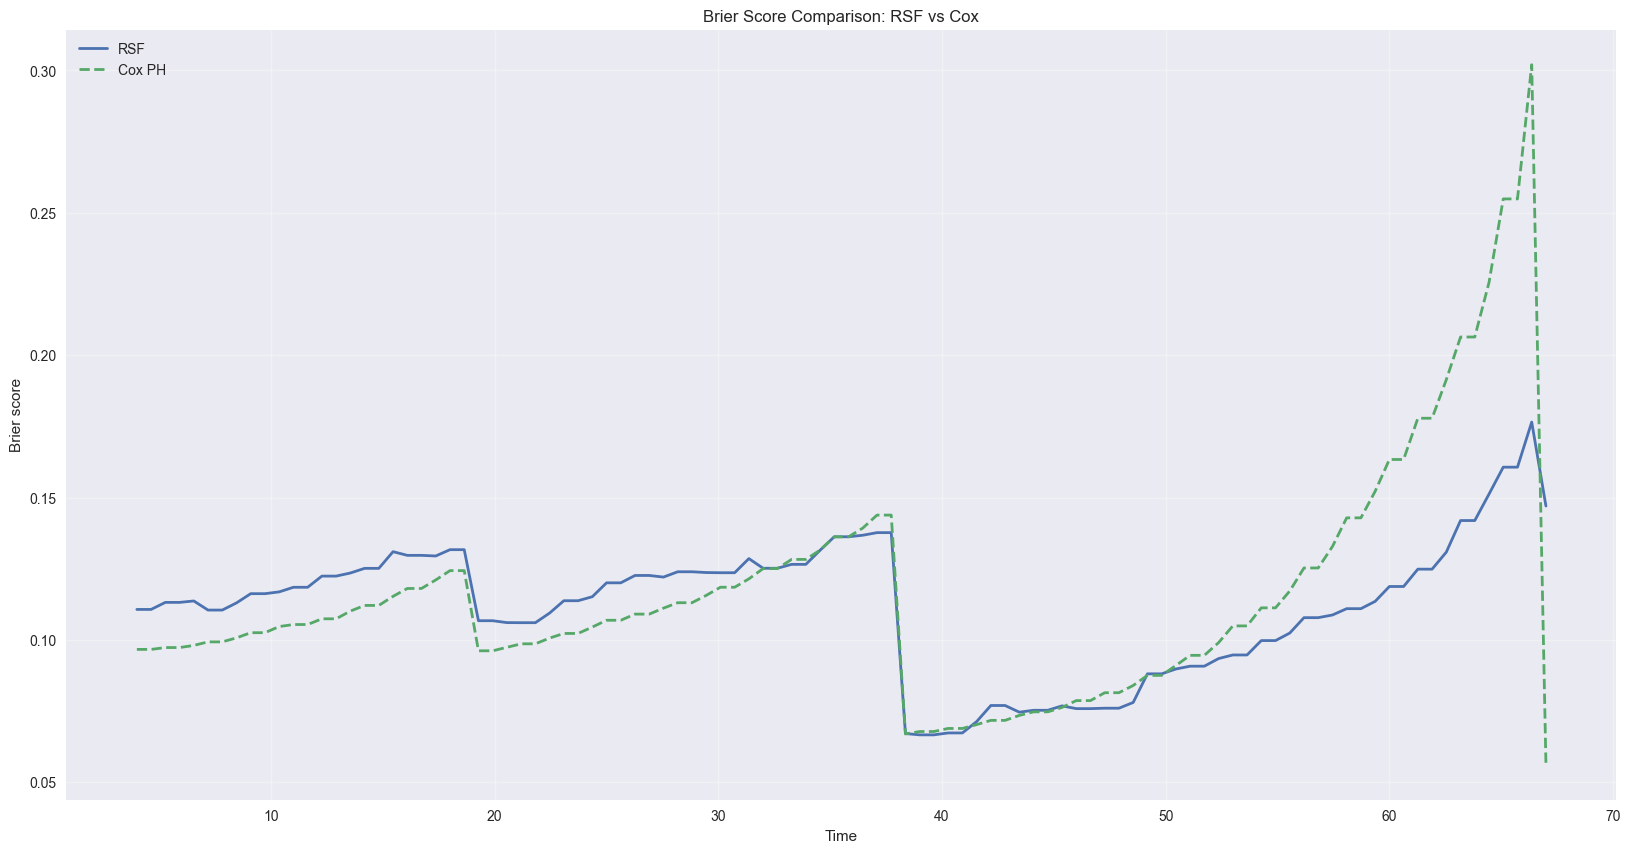

In [23]:
# Cox Brier score
_, brier_cox = brier_score(
    y_train,
    y_test,
    surv_preds_cox,
    times
)

plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
plt.plot(times, brier_rsf, label="RSF", linewidth=2)
plt.plot(times, brier_cox, label="Cox PH", linewidth=2, linestyle="--")

plt.xlabel("Time")
plt.ylabel("Brier score")
plt.title("Brier Score Comparison: RSF vs Cox")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

This code calculates and visualizes the time-dependent Brier scores for both the Random Survival Forest (RSF) and Cox Proportional Hazards models, allowing a direct comparison of their calibration over time.

First, it calculates the Brier score as a function of time for the Cox model using the `brier_score` function from `scikit-survival.metrics`. The training data (`y_train`), test data (`y_test`), predicted survival probabilities (`surv_preds_cox`), and time points (`times`) are provided as input. The function returns two arrays; the first (time points) is assigned to `_` because it's not needed, while the second (Brier scores) is assigned to `brier_cox`.

Next, a plot is created with dimensions specified by `CFG.img_dim1` and `CFG.img_dim2`. The code then plots the time-dependent Brier score for both models: 
*   The RSF Brier score (`brier_rsf`) is plotted as a solid line labeled "RSF" with a linewidth of 2.
*   The Cox Proportional Hazards Brier score (`brier_cox`) is plotted as a dashed line labeled "Cox PH" with a linewidth of 2 and a dashed linestyle.

The plot includes labels for the x and y axes ("Time" and "Brier score", respectively), a title ("Brier Score Comparison: RSF vs Cox"), a legend, and a grid for improved readability. Finally, `plt.show()` displays the generated plot, allowing visual comparison of the calibration performance of the two models over time.